<a href="https://colab.research.google.com/github/sejin-sim/Competitions/blob/main/%5BKAGGLE%5D_IEEE_CIS_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사기 감지 (fraud detection)

anomaly detection

데이터로부터 p(x) 를 만들어, 검사할 데이터가 threshold 를 넘는지 안넘는지 검사해 anomaly 로 판정할 수 있다.

참고로, anomaly 가 너무 많으면, false positive 가 높은 것인데 이 때는 threshold 를 줄이면 된다.

Categorical Features - Transaction

- ProductCD
-emaildomain
-card1 - card6
-addr1, addr2
-P_emaildomain
-R_emaildomain
-M1 - M9

Categorical Features - Identity

- DeviceType
-DeviceInfo
-id_12 - id_38

In [ ]:
! cp /content/drive/MyDrive/kaggle/kaggle.json /root/.kaggle/
! kaggle competitions download -c ieee-fraud-detection

sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# ! git clone --recursive https://github.com/Microsoft/LightGBM
# ! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

In [ ]:
train_transaction = pd.read_csv('/content/train_transaction.csv.zip', index_col='TransactionID')
test_transaction = pd.read_csv('/content/test_transaction.csv.zip', index_col='TransactionID')

train_identity = pd.read_csv('/content/train_identity.csv.zip', index_col='TransactionID')
test_identity = pd.read_csv('/content/test_identity.csv.zip', index_col='TransactionID')

sample_submission = pd.read_csv('/content/sample_submission.csv.zip', index_col='TransactionID')

train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

y_train = train['isFraud'].copy()
del train_transaction, train_identity, test_transaction, test_identity

# Drop target, fill in NaNs
X_train = train.drop('isFraud', axis=1)
X_test = test.copy()

del train, test

In [ ]:
y_train.value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

train target = binary 형태

test target = roc curve 확률

In [ ]:
X_test=X_test.rename(columns={'id-01':'id_01','id-02':'id_02','id-03':'id_03','id-04':'id_04','id-05':'id_05',
                         'id-06':'id_06','id-07':'id_07','id-08':'id_08','id-09':'id_09',
                         'id-10':'id_10','id-11':'id_11','id-12':'id_12','id-13':'id_13','id-14':'id_14',
                         'id-15':'id_15','id-16':'id_16','id-17':'id_17','id-18':'id_18','id-19':'id_19',
                         'id-20':'id_20','id-21':'id_21','id-22':'id_22','id-23':'id_23','id-24':'id_24',
                         'id-25':'id_25','id-26':'id_26','id-27':'id_27','id-28':'id_28','id-29':'id_29',
                         'id-30':'id_30','id-31':'id_31','id-32':'id_32','id-33':'id_33','id-34':'id_34',
                         'id-35':'id_35','id-36':'id_36','id-37':'id_37','id-38':'id_38'})

In [ ]:
# 데이터 프레임 데이터 타입을 바꿈으로써 전체적인 데이터 사용량을 줄임

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
## REducing memory
X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)

Mem. usage decreased to 667.66 Mb (66.1% reduction)
Mem. usage decreased to 583.43 Mb (65.6% reduction)


In [ ]:
# fill in NaNs
for c in X_train.columns:
    if X_train[c].dtype=='float16' or  X_train[c].dtype=='float32' or  X_train[c].dtype=='float64':
        X_train[c].fillna(X_train[c].mean())
        X_test[c].fillna(X_train[c].mean())

X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)

In [ ]:
# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))  

In [ ]:
!pip install bayesian-optimization

In [ ]:
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
import xgboost as xgb
        
X = X_train
y = y_train

def XGB_cv(max_depth, gamma, colsample_bytree, min_child_weight):
    
    model = xgb.XGBClassifier(
                              use_label_encoder=False,
                              tree_method = 'gpu_hist',
                              predictor = 'gpu_predictor',
                              metric= 'auc',

                              max_depth = int(max_depth),   
                              gamma=gamma,
                              colsample_bytree=colsample_bytree,
                              min_child_weight = int(min_child_weight))
    
    cval = cross_val_score(model, X, y, scoring='roc_auc', cv=5).mean()
    return cval

# 주어진 범위 사이에서 적절한 값을 찾는다.
pbounds={
    'max_depth': (7,14),
    'gamma': (0, 1),
    'colsample_bytree': (0.5, 1.0),
    'min_child_weight' : (1, 3)      
}

xgboostBO = BayesianOptimization(f = XGB_cv,pbounds = pbounds, verbose = 2, random_state = 1 )

xgboostBO.maximize(init_points=10, n_iter = 10)
# n_iter : 수행하려는 베이지안 최적화 단계. 더 많은 단계를 거치면 더 좋은 최대치 얻음
# init_points : 수행할 무작위 탐색 단계

print(xgboostBO.max) # 찾은 파라미터 값 확인

fit_xgb = xgb.XGBClassifier(
                            max_depth= int(xgboostBO.max['params']['max_depth'] ),
                            gamma= xgboostBO.max['params']['gamma'],
                            colsample_bytree=xgboostBO.max['params']['colsample_bytree'],
                            min_child_weight = int(xgboostBO.max['params']['min_child_weight']),

                            metric= 'auc',
                            use_label_encoder=False,
                            tree_method = 'gpu_hist',
                            predictor = 'gpu_predictor')


model  = fit_xgb.fit(X, y)
pred_xgb = model.predict_proba(X_test)

|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... |
-------------------------------------------------------------------------
|  1        |  0.8777   |  0.7085   |  0.7203   |  7.001    |  1.605    |
|  2        |  0.8789   |  0.5734   |  0.09234  |  7.931    |  1.691    |
|  3        |  0.8889   |  0.6984   |  0.5388   |  9.096    |  2.37     |
|  4        |  0.8788   |  0.6022   |  0.8781   |  7.137    |  2.341    |
|  5        |  0.8777   |  0.7087   |  0.5587   |  7.702    |  1.396    |
|  6        |  0.8805   |  0.9004   |  0.9683   |  8.567    |  2.385    |
|  7        |  0.8751   |  0.9382   |  0.8946   |  7.425    |  1.078    |
|  8        |  0.879    |  0.5849   |  0.8781   |  7.492    |  1.842    |
|  9        |  0.8769   |  0.9789   |  0.5332   |  10.46    |  1.631    |
|  10       |  0.8735   |  0.8433   |  0.8346   |  7.091    |  2.5      |
|  11       |  0.8969   |  0.6018   |  0.9192   |  11.93    |  2.969    |
|  12       |  0.8966   |  0.634    | 

In [ ]:
model.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5363034369458757,
              gamma=0.2408675804291115, learning_rate=0.1, max_delta_step=0,
              max_depth=11, metric='auc', min_child_weight=2, missing=None,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', predictor='gpu_predictor',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, tree_method='gpu_hist',
              use_label_encoder=False, verbosity=1)>

In [ ]:
sample_submission['isFraud'] = pred_xgb[:,1]
sample_submission.to_csv('/content/drive/MyDrive/kaggle/ieee/xgboost_bo.csv')
!kaggle competitions submit -c ieee-fraud-detection -f /content/drive/MyDrive/kaggle/ieee/xgboost_bo.csv -m "Message"

100% 9.78M/9.78M [00:00<00:00, 24.7MB/s]
Successfully submitted to IEEE-CIS Fraud Detection

- 최종 스코어

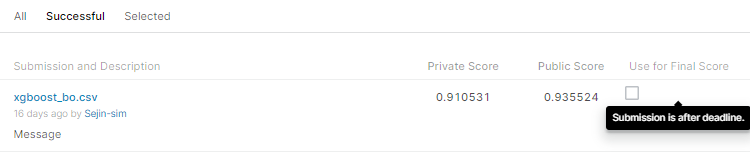